In [1]:
%load_ext jupyter_black

In [2]:
from IPython.core.display import Image


import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

import fast_spa

ZENITH_ANGLE = 0
AZIMUTH_ANGLE = 1

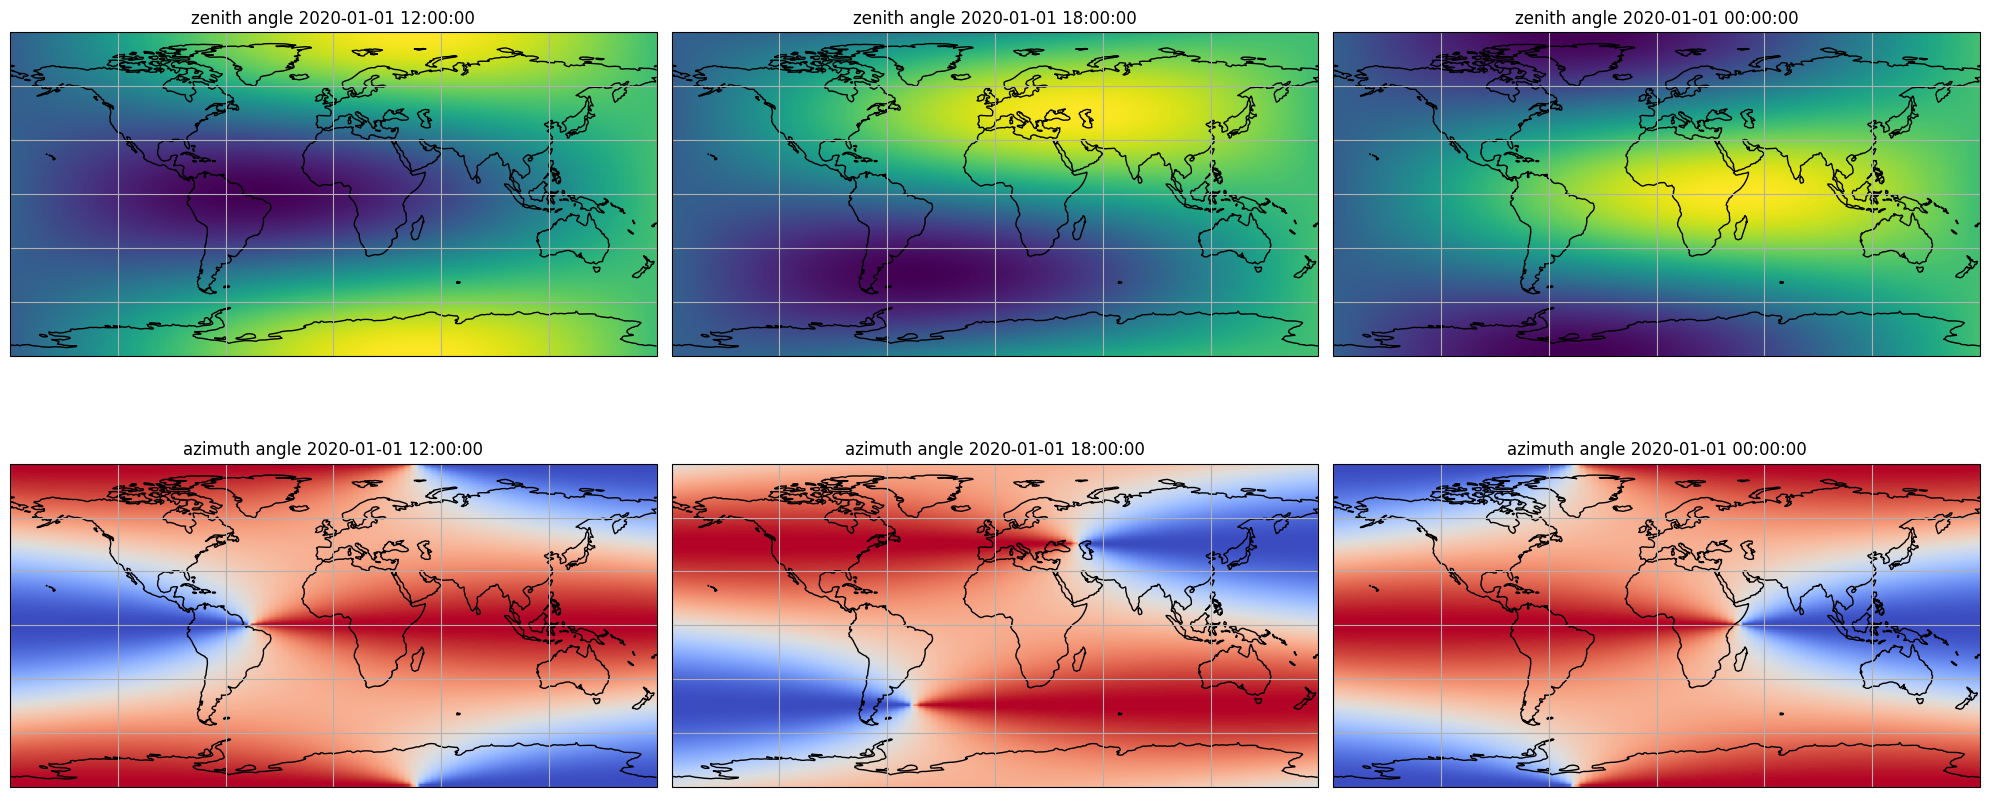

In [54]:
# CONUS
import datetime
import matplotlib.colors
lats = np.linspace(-90, 90, 100)
lons = np.linspace(-180, 180, 200)
lats, lons = np.meshgrid(lats, lons)

channels = [ZENITH_ANGLE, AZIMUTH_ANGLE]
name = ["zenith",  "azimuth"]

datetime_obj = [
    datetime.datetime(2020, 1, 1, 12, 0, 0),
    datetime.datetime(2020, 1, 1, 18, 0, 0),
    datetime.datetime(2020, 1, 1, 0, 0, 0),
]

data = fast_spa.fast_spa(datetime_obj, lats, lons)

data = np.cos(np.radians((data + 180) % 360))



fig, axes = plt.subplots(
    len(channels),
    3,
    figsize=(20, 10),
    subplot_kw={"projection": ccrs.PlateCarree()},
)
fig.tight_layout()
extent = [lons.min(), lons.max(), lats.min(), lats.max()]
for i in range(len(datetime_obj)):
    ax1, ax2 = axes[:, i]

    zen, azi = data[:,  i]
    ax1.imshow(zen, origin="lower", extent=extent)
    ax1.set_title(
        f"{name[0]} {datetime_obj[i].strftime('%Y-%m-%d %H:%M:%S')}"
    )
    ax1.coastlines()
    ax1.gridlines()
    ax1.set_title(
        f"zenith angle {datetime_obj[i].strftime('%Y-%m-%d %H:%M:%S')}"
    )

    ax2.coastlines()
    ax2.gridlines()
    ax2.imshow(
        azi, 
        origin="lower", 
        extent=extent,
        cmap="coolwarm",
    )
    ax2.set_title(
        f"azimuth angle {datetime_obj[i].strftime('%Y-%m-%d %H:%M:%S')}"
    )


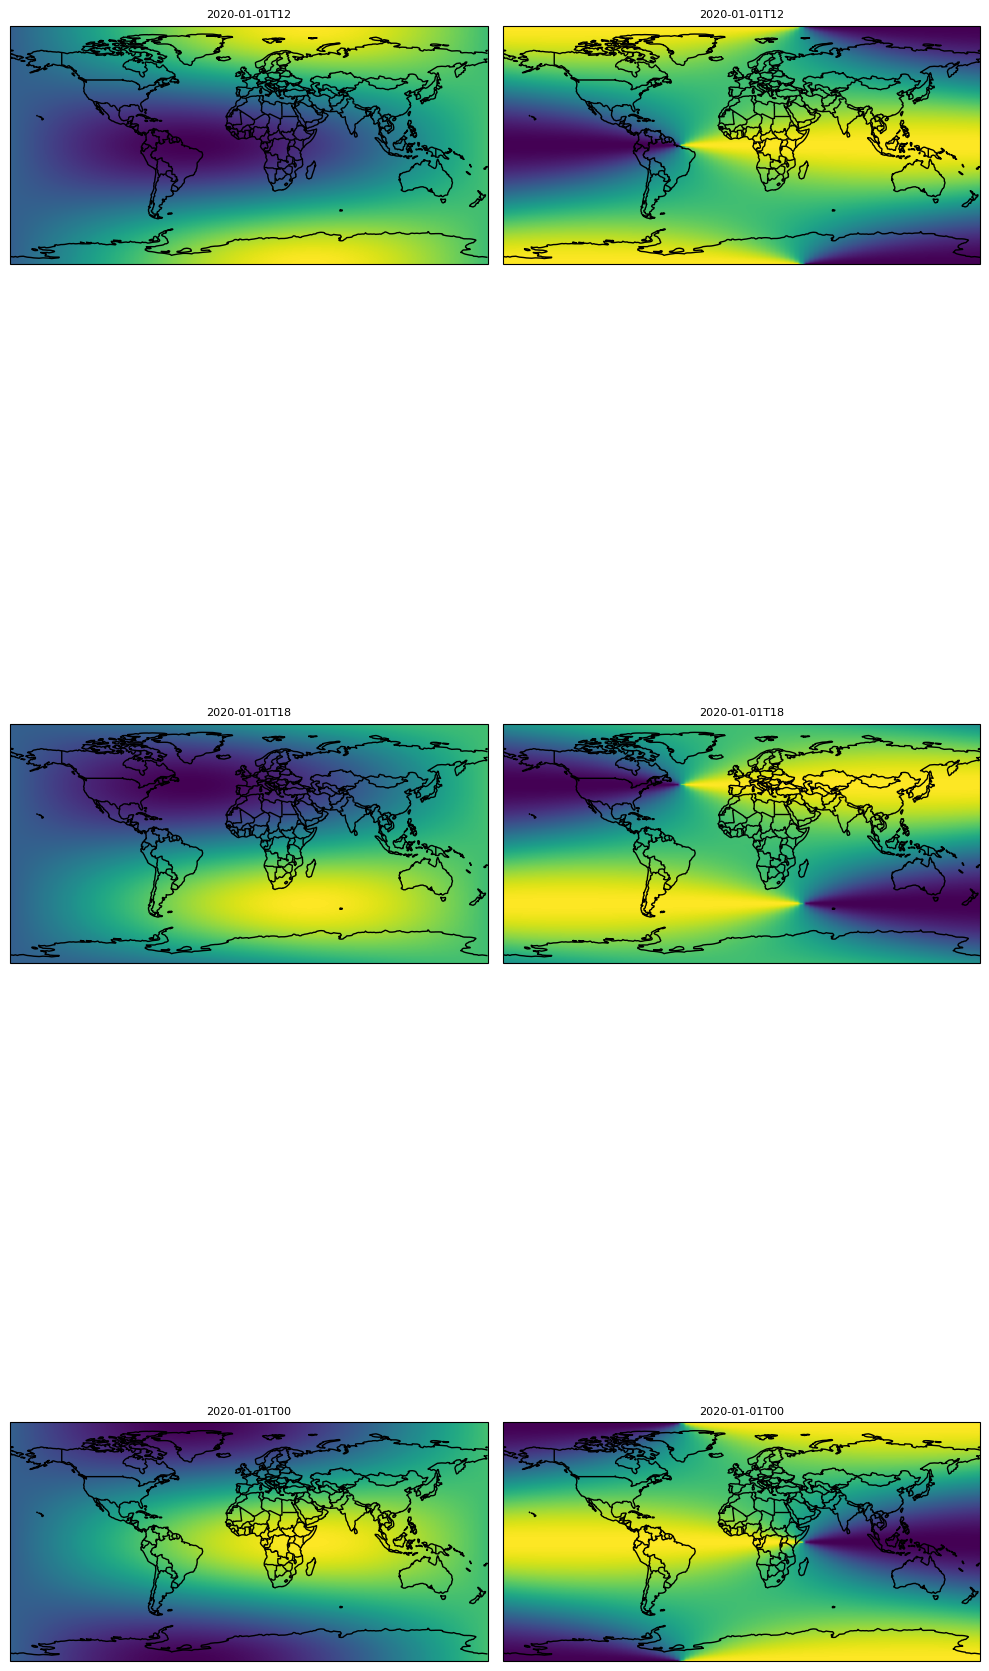

In [55]:
num_channels, num_time = data.shape[:2]
fig, axes = plt.subplots(
    nrows=num_time,
    ncols=num_channels,
    figsize=(10, 25),
    subplot_kw={"projection": ccrs.PlateCarree()},
)
extent = [lons.min(), lons.max(), lats.min(), lats.max()]

title = [
    "zenith angle",
    "aparent zenith angle",
    "elevation angle",
    "aparent elevation angle",
    "azimuth angle",
]
fig.tight_layout()


for i in range(num_channels):
    for j in range(num_time):
        ax = axes[j, i]
        assert isinstance(ax, GeoAxes)
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.imshow(
            data[i, j, :, :], transform=ccrs.PlateCarree(), extent=extent
        )
        ax.title.set_text(
            np.datetime64(datetime_obj[j]).astype("datetime64[h]")
        )
        ax.set_title(
            np.datetime64(datetime_obj[j]).astype("datetime64[h]"),
            {
                "fontsize": 8,
                "verticalalignment": "baseline",
                "horizontalalignment": "center",
            },
        )

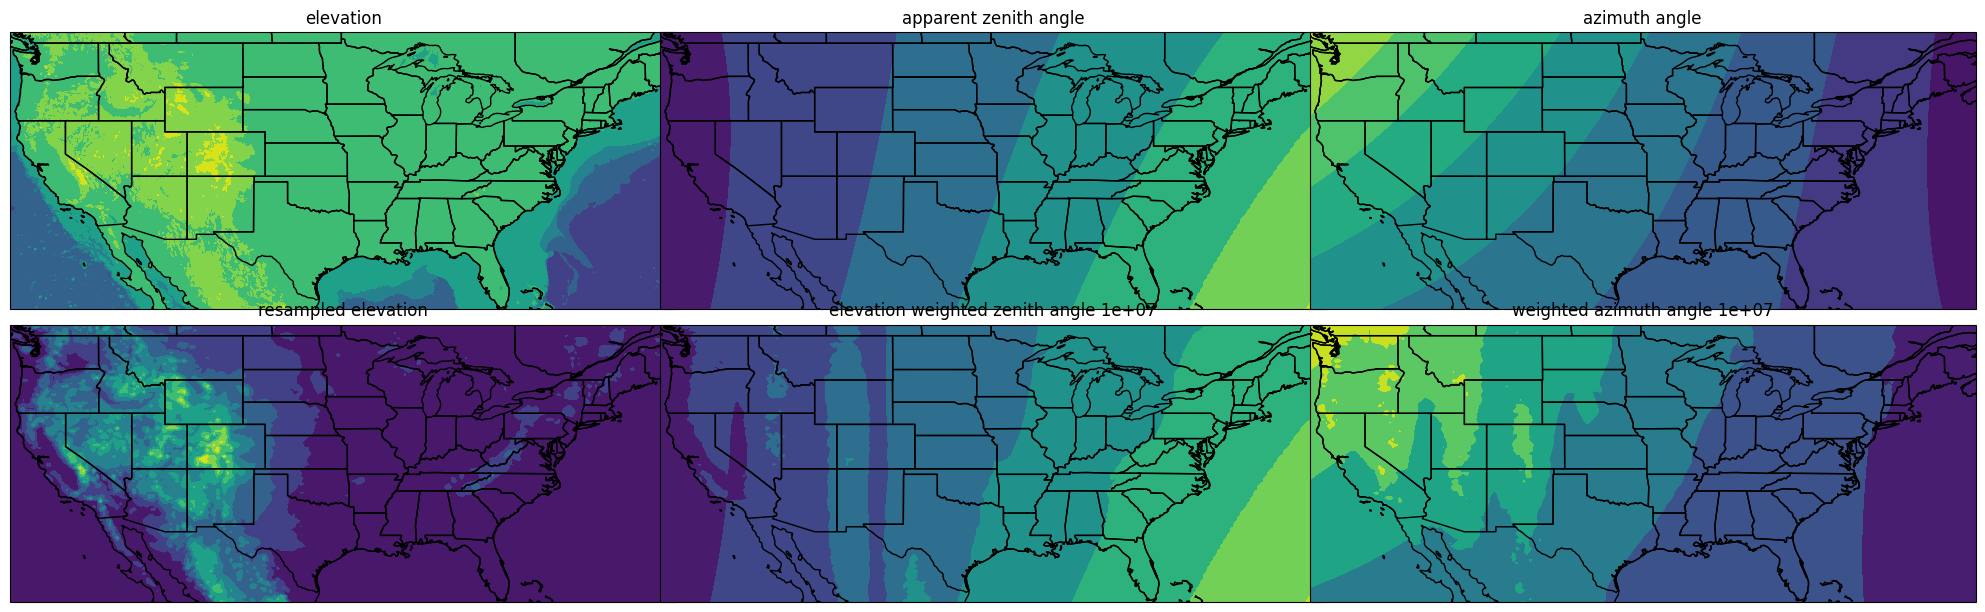

In [65]:
from numpy.typing import ArrayLike




def contourf(
    ax: GeoAxes, data: ArrayLike, lons: ArrayLike, lats: ArrayLike, title=""
) -> GeoAxes:
    ax.title.set_text(title)
    ax.coastlines()
    ax.add_feature(cfeature.STATES)
    ax.contourf(
        lons,
        lats,
        data,
        transform=ccrs.PlateCarree(),
    )
    return ax


def main(
    etopo: fast_spa.ETOPO2022 = fast_spa.ETOPO2022(),
    lons=np.linspace(-125, -65, 200),
    lats=np.linspace(25, 50, 100),
    weight: float = 1e7,
):
    lons, lats = np.meshgrid(lons, lats)
    y_mask = np.logical_and(etopo.lat >= lats.min(), etopo.lat <= lats.max())
    x_mask = np.logical_and(etopo.lon >= lons.min(), etopo.lon <= lons.max())
    source_lons = etopo.lon[x_mask]
    source_lats = etopo.lat[y_mask]

    fig, axes = plt.subplots(
        2, 3, figsize=(20, 6), subplot_kw={"projection": ccrs.PlateCarree()}
    )
    fig.tight_layout()

    elevation = etopo.resample(lons, lats)
    elevation[elevation < 0] = 0

    spa_data = fast_spa.fast_spa(datetime_obj, lats, lons, elevation)
    spa_data = np.cos(np.radians((spa_data + 180) % 360))
    weighted = fast_spa.fast_spa(datetime_obj, lats, lons, elevation * weight)
    weighted = np.cos(np.radians((weighted + 180) % 360))

    contourf(
        axes[0, 0],
        etopo[y_mask, x_mask],
        source_lons,
        source_lats,
        "elevation",
    )

    contourf(axes[1, 0], elevation, lons, lats, "resampled elevation")

    contourf(
        axes[0, 1],
        spa_data[ZENITH_ANGLE, 0, :, :],
        lons,
        lats,
        "apparent zenith angle",
    )
    contourf(
        axes[1, 1],
        weighted[ZENITH_ANGLE, 0, :, :],
        lons,
        lats,
        f"elevation weighted zenith angle {weight:.0e}",
    )

    # )

    contourf(
        axes[0, 2],
        spa_data[AZIMUTH_ANGLE, 0, :, :],
        lons,
        lats,
        "azimuth angle",
    )
    contourf(
        axes[1, 2],
        weighted[AZIMUTH_ANGLE, 0, :, :],
        lons,
        lats,
        f"weighted azimuth angle {weight:.0e}",
    )
    plt.show()


main()

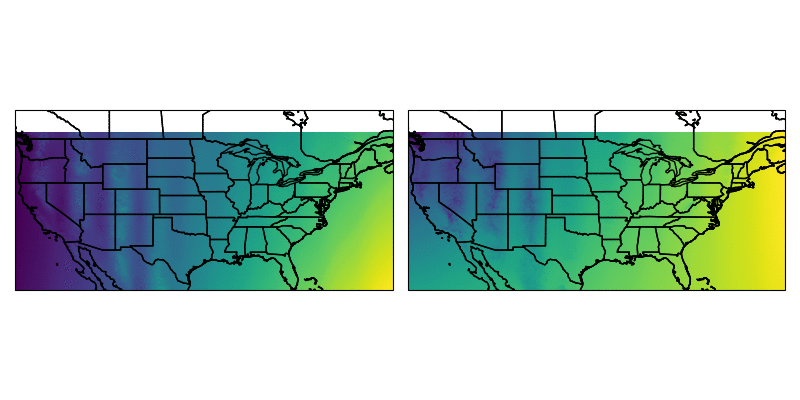

In [69]:
import fast_spa.display
from matplotlib.colors import ListedColormap

# ----------------
kind = ""

datetime_obj = np.arange("2023-07-01", "2023-07-02", dtype="datetime64[h]")[
    :24
].astype("datetime64[ns]")
# - colorado
if kind == "COLORADO":
    lats = np.linspace(36, 45, 100)
    lons = np.linspace(-110, -90, 200)
else:
    lats = np.linspace(-90, 90, 100)
    lons = np.linspace(-180, 180, 200)

lons=np.linspace(-125, -65, 200)
lats=np.linspace(25, 50, 100)
lons, lats = np.meshgrid(lons, lats)

# # ----------------

etopo = fast_spa.ETOPO2022()
weight = 1e7
# weight = 1
elevation = etopo.resample(lons, lats)
elevation[elevation < -100] = -100

# A = fast_spa.FastSPA(datetime_obj, lats, lons, elevation)
data = fast_spa.fast_spa(datetime_obj, lats, lons, elevation * weight)
data = np.cos(np.radians((data + 180) % 360))
# invert the azimuth angle
data[AZIMUTH_ANGLE] *= -1

features = [
    cfeature.STATES,
    cfeature.COASTLINE,
    cfeature.BORDERS,
]
extent = [lons.min(), lons.max(), lats.min(), lats.max()]

anim = fast_spa.display.AutoAnimator(
    data,
    extent=extent,
    features=features,
)
anim.save(
    "samples.gif",
    writer="imagemagick",
    fps=1,
    extra_args=["-layers", "optimize"],
)
plt.close()
Image("samples.gif")

In [7]:
from matplotlib.colors import ListedColormap

one_180_cmap = ListedColormap(["black", "white"])

In [8]:
x = data[-1]
x.min(), x.max()

(4.294170396690333e-05, 359.9999997830538)

In [9]:
a, b, c = B.apparent
print((a.min(), a.max()), (b.min(), b.max()), (c.min(), c.max()))

apparent_min_max = [
    {
        "vmin": 0.0,
        "vmax": 180,
    },
    {
        "vmin": -90,
        "vmax": 90,
    },
    {
        "vmin": 0.0,
        "vmax": 360,
    },
]

NameError: name 'B' is not defined

In [ ]:
# B = fast_spa.FastSPA(
#     np.arange("2023-01-01", "2023-02-01", dtype="datetime64[h]")[:24].astype(
#         "datetime64[ns]"
#     ),
#     lats,
#     lons,
#     elevation * weight,
# )
# data = B.apparent
# data = np.radians(data % 360)
# # data[2] = np.radians(data[2])
# print(data.shape)
# (data[0].max(), data[0].min()), (data[1].max(), data[1].min()), (
#     data[2].max(),
#     data[2].min(),
# )

In [ ]:
np.radians(fast_spa.fast_spa(datetime_obj, lats, lons, elevation)[4])[None]

In [ ]:
import scipy.interpolate
from scipy.interpolate import NearestNDInterpolator
import numpy as np
import matplotlib.pyplot as plt

R = 6370997.0


def _points(lons: np.ndarray, lats: np.ndarray) -> np.ndarray:
    """
    >>> lons = np.linspace(-80, -78, 200)
    >>> lats = np.linspace(30, 31, 100)
    >>> lons, lats = np.meshgrid(lons, lats)
    >>> coords = xyz(lons.ravel(), lats.ravel())
    >>> coords.shape
    (20000, 3)
    """
    xx, yy = (np.radians(arr.ravel()) for arr in (lons, lats))
    return np.c_[
        R * np.cos(yy) * np.cos(xx),
        R * np.cos(yy) * np.sin(xx),
        R * np.sin(yy),
    ]


from typing import Literal

Methods = Literal["linear", "nearest", "cubic", "kd"]


def resmp(
    self,
    lons: np.ndarray,
    lats: np.ndarray,
    leafsize=16,
    k=3,
    eps=0,
    distance_upper_bound=None,
    sqr_dists=False,
    mask=None,
    method: Methods = "kd",
):
    if lons.shape != lats.shape:
        lons, lats = np.meshgrid(lons, lats)
    assert (lons.ndim == lats.ndim == 2) & (lons.shape == lats.shape)
    shape = lons.shape
    y_mask = np.logical_and(self.lat >= lats.min(), self.lat <= lats.max())
    x_mask = np.logical_and(self.lon >= lons.min(), self.lon <= lons.max())
    xx, yy = np.meshgrid(self.lon[x_mask], self.lat[y_mask])
    data = self[y_mask, x_mask].ravel()
    if method != "kd":
        import scipy.interpolate

        points = (xx.ravel(), yy.ravel())
        return scipy.interpolate.griddata(
            points, data, (lons, lats), method=method
        )

    points = _points(xx, yy)
    _, i = self._tree(points, leafsize=leafsize).query(
        _points(lons, lats),
        k=k,
        eps=eps,
        distance_upper_bound=distance_upper_bound,
        sqr_dists=sqr_dists,
        mask=mask,
    )
    return np.mean(data[i], axis=1).reshape(shape)


# rng = np.random.default_rng()
# # x = rng.random(10) - 0.5
# # y = rng.random(10) - 0.5
lons = np.linspace(-125, -65, 200)
lats = np.linspace(25, 50, 100)

# print(Z0.shape)
extent = [lons.min(), lons.max(), lats.min(), lats.max()]
fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1, figsize=(10, 25), subplot_kw={"projection": ccrs.PlateCarree()}
)
kd = resmp(etopo, lons, lats, method="kd")
nn = resmp(etopo, lons, lats, method="nearest")
diff = np.abs(kd - nn)
ax1.imshow(kd, origin="lower", extent=extent)
ax1.title.set_text("kd")
ax2.imshow(nn, origin="lower", extent=extent)
ax2.title.set_text("nearest")
ax3.imshow(diff, origin="lower", extent=extent)
ax3.title.set_text("diff")

In [ ]:
Z1 = etopo.resample(lons, lats)
print(Z1.shape)
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
ax.imshow(
    Z1, origin="lower", extent=[lons.min(), lons.max(), lats.min(), lats.max()]
)

In [ ]:
np.allclose(Z0, Z1, rtol=1)

In [ ]:
# from matplotlib.animation import FuncAnimation
# from matplotlib.image import AxesImage
# from cartopy.mpl.geoaxes import GeoAxes
# import numpy as np
# import fast_spa
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# from cartopy.mpl.geoaxes import GeoAxes
# import cartopy.feature as cfeature
# from numpy.typing import ArrayLike

# from typing import TYPE_CHECKING, Any, Mapping, Sequence
# import itertools
# import matplotlib.pyplot as plt
# import numpy as np
# from matplotlib import colormaps  # type: ignore
# from matplotlib.animation import FuncAnimation
# from matplotlib.axes import Axes
# from matplotlib.colors import BoundaryNorm, ListedColormap, Normalize
# from matplotlib.figure import Figure
# from matplotlib.image import AxesImage


# class AutoAnimator(FuncAnimation):
#     images: list[AxesImage]

#     def __init__(
#         self,
#         data: np.ndarray,
#         extent: Sequence[float],
#         origin: str = "lower",
#         **kwargs: Any,
#     ):
#         if data.ndim == 4:
#             data = data[np.newaxis, ...]
#         assert data.ndim == 5
#         self.extent = extent
#         self.origin = origin

#         # construct figure and axes
#         B, C, T, L, W = data.shape
#         fig, ax = self._subplots(rows=B, channels=C)

#         # reshape data to 4D tensor
#         data = data.reshape(-1, T, L, W)
#         # config = config or list(itertools.repeat({}, C))

#         self.images = [
#             self._imshow(ax[row, col], data[row * C + col, 0])
#             for row, col in itertools.product(range(B), range(C))
#         ]

#         self.data = data

#         super().__init__(
#             fig,
#             self._animate,
#             init_func=lambda: self.images,
#             frames=T,
#             blit=True,
#             **kwargs,
#         )

#     # @staticmethod
#     def _subplots(
#         self, rows: int, *, channels: int
#     ) -> tuple[Figure, Mapping[tuple[int, int], Axes]]:
#         # TODO: determine best scaling factor
#         scale = 4

#         fig, axes = plt.subplots(
#             rows,
#             channels,
#             figsize=(scale * channels, scale * rows),
#             sharex=True,
#             sharey=True,
#             subplot_kw=dict(projection=ccrs.PlateCarree()),
#         )  # type: ignore
#         fig.tight_layout()

#         if rows == 1:
#             axes = axes[np.newaxis, ...]

#         x, y = axes.shape
#         for i in range(x):
#             for j in range(y):
#                 ax = axes[i, j]
#                 ax.coastlines()
#                 ax.set_extent(self.extent)

#         return fig, axes  # type: ignore

#     def _animate(self, tidx: int) -> list[AxesImage]:
#         for i in range(len(self.images)):
#             self.images[i].set_data(self.data[i, tidx, ...])
#         return self.images

#     def _imshow(self, ax, data):
#         return ax.imshow(
#             data,
#             origin=self.origin,
#             extent=self.extent,
#             transform=ccrs.PlateCarree(),
#             animated=True,
#         )


# from IPython.core.display import Image

# datetime_obj = np.arange(
#     "2023-01-01", "2023-01-02", dtype="datetime64[h]"
# ).astype(
#     "datetime64[ns]"
# )  # [:2]
# # lats = np.linspace(25, 50, 100)
# # lons = np.linspace(-125, -65, 100)
# # datetime_obj
# # COLORADO
# lons = np.linspace(-180, 180, 200)
# lats = np.linspace(-90, 90, 100)
# weight = 1e3
# # conus
# # lons = np.linspace(-125, -65, 200)
# # lats = np.linspace(25, 50, 100)


# lons, lats = np.meshgrid(lons, lats)
# # etopo = fast_spa.ETOPO2022()
# # elevation = etopo.resample(lons, lats)
# # spa_data = fast_spa.fast_spa(datetime_obj, lats, lons, elevation)
# weighted = fast_spa.fast_spa(datetime_obj, lats, lons)[::2]


# extent = [lons.min(), lons.max(), lats.min(), lats.max()]


# anim = AutoAnimator(weighted, extent=extent)
# anim.save(
#     "samples.gif",
#     writer="imagemagick",
#     fps=6,
#     extra_args=["-layers", "optimize"],
# )
# plt.close()
# Image("samples.gif")

In [ ]:
weight = 1e7

# conus
lons = np.linspace(-125, -65, 200)
lats = np.linspace(25, 50, 100)


lons, lats = np.meshgrid(lons, lats)
etopo = fast_spa.ETOPO2022()
elevation = etopo.resample(lons, lats)

spa_data = fast_spa.fast_spa(
    datetime_obj, lats, lons, elevation * weight
)

In [ ]:
plt.imshow(
    spa_data[1, 0],
)